# Pokémon Search Engine 

#### Motivation: 
In the last 2 years, the hype around Pokemon has increased rapidly. Driven by Youtubers like Logan Paul, a first edition Charzard can now reach 400,000 or more. (Sparks, 2022)
So it's only logical that this hype has also introduced many new people to Pokemon. Each card is characterized by an illustration, but also properties (e.g. Type, Species, Abilities). Therefore, the goal is to provide Pokémon interested people with the appropriate information about the Pokemon, simply by using an image search. 

# General

## Imports

All required Libraries that are needed throughout the project are imported here.

In [1]:
try: 
    from imutils.paths import list_images
    from matplotlib import pyplot as plt
    from scipy.spatial import distance as dist
    from PIL import Image
    import pickle, imutils, cv2, mahotas 
    import numpy as np
    print("Import sucessfull.")
except :
    print("Error occured.")

Import sucessfull.


## Helper Functions

Process contiously used throughout the process of loading images, aswell as store and load indexes are stored here in order to avoid repeated code and ease the understanding  

In [2]:
def store_index(index,name,out_path):
    f = open(out_path+"/"+name+".cpickle", "wb")
    f.write(pickle.dumps(index))
    f.close()

def load_index(input_path):
    index = open(input_path, "rb").read()
    index = pickle.loads(index)
    return index

def load_image(input_path):
    image =  cv2.imread(input_path)
    image = cv2.resize(image, [120,120])#,fx=0.1, fy=0.1
    return image
    

## Data Preperation

Since images differ from each other, we need a way to standardize the images, e.g white and transparent backgounds to only white background. 

In [3]:
#Convert all backgrounds to white
def convert_bg_to_white(inp_path : str, out_path : str):
    img_path = inp_path
    for spritePath in list_images(img_path):
        pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
        image = cv2.imread(spritePath)
        image = Image.open(spritePath).convert("RGBA")
        new_image = Image.new("RGBA", image.size, "WHITE")
        new_image.paste(image, mask=image)
        new_image.convert("RGB").save(out_path+pokemon.split('\\')[1]+".png")
    return 

convert_bg_to_white("./images","./images_prepared/")

## Methods of describing and indexing

#### Color Discriptor

The color dischriber uses the rgb channels of an image to describe in a histogram the nature of an image. 

In [4]:
def img_to_color_hist(image): 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([image], [0, 1, 2], None, [8, 8, 8],[0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def img_to_color_index(inp_path : str, out_path : str):
    index = dict()
    for spritePath in list_images(inp_path):
        pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
        image = cv2.imread(spritePath)
        index[pokemon] = img_to_color_hist(image)
    store_index(index,"cindex",out_path)
    return 

img_to_color_index("./images_prepared", "./indexes")

#### Greyscale Discriptor

The greyscale discriptor uses the pixel intensities and a histogram to describe the nature of an image

In [5]:
def img_to_greyscale_hist(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def img_to_greyscale_index(inp_path : str, out_path : str):
    index = dict()
    for spritePath in list_images(inp_path):
        pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
        image = cv2.imread(spritePath)
        index[pokemon] = img_to_greyscale_hist(image)
    store_index(index,"gindex",out_path)
    return 

img_to_greyscale_index("./images_prepared", "./indexes")

#### Shape Discriptor

Functions used for the process of creating an shape discriptor and indexing the outcome.

1.) img_to_gs_shape: This function takes a image as input, and preprocessing it. Outcome is a black and white segmented image.
<br/>
2.) img_to_index: This function loops over all the pokemon database. With the use of img_to_gs_shape() all pokemons are described based on their outline and returned. The described pokemon is indexed in a dictionary where the pokemon acts as key. After all pokemon are indexed, the index is saved to a file

In [6]:
# Segmentation of the image
# https://pyimagesearch.com/2014/04/07/building-pokedex-python-indexing-sprites-using-shape-descriptors-step-3-6/
def img_to_gs_shape(img): 
        image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        image = cv2.copyMakeBorder(image, 15, 15, 15, 15,
            cv2.BORDER_CONSTANT, value = 255)
        thresh = cv2.bitwise_not(image)
        thresh[thresh > 0] = 255
        outline = np.zeros(image.shape, dtype = "uint8")
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
        cv2.drawContours(outline, [cnts], -1, 255, -1)
        return mahotas.features.zernike_moments(outline, 33)

#Indexing outlined pokemons and saves them to an index file. 
def img_to_index(inp_path, out_path): 
    index = dict()
    for spritePath in list_images(inp_path):
        pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png", "")
        image = cv2.imread(spritePath)
        index[pokemon] = img_to_gs_shape(image)
    store_index(index,"sindex",out_path)

img_to_index("./images_prepared", "./indexes")

### Load Indexes

In [7]:
color_idx = load_index("./indexes/cindex.cpickle")
greyscale_idx = load_index("./indexes/gindex.cpickle")
shape_idx = load_index("./indexes/sindex.cpickle")

## Methods for comaparison

This section aims on comparing and finding pokemons based on new insert images. Therefore the user has to specify an pokemon and based on the already created index, the most similiar pokemon (distance-wise) is outputed.

#### 1) Distance Computation (Euclidean,Manhattan)

In [8]:
#Methods dist.euclidean, dist.cityblock
def compute_distance(image_hist, index, method):
    results = {}
    for hist in index:
        results[hist] = method(image_hist, index[hist])
    results = sorted([(v, k) for (k, v) in results.items()])[:4]
    return results[:4]

#### 2) Histogram Comparison (ChiSquared, Hellinger)

In [9]:
#methods = cv2.HISTCMP_CHISQR or cv2.HISTCMP_BHATTACHARYYA
def compare_hist(image_hist, index, method):
    results = dict()
    #Outsource this redundant part
    for hist in index:
        results[hist] = cv2.compareHist(image_hist, index[hist], method)
    results = sorted([(v, k) for (k, v) in results.items()], reverse = False)[:4]
    return results[:4]

#### 3) Shape Comparison

In [10]:
def compare_shapes(index, queryFeatures):
    # initialize our dictionary of results
    results = {}
    for (k, features) in index.items():
        d = dist.euclidean(queryFeatures, features)
        results[k] = d
    results = sorted([(v, k) for (k, v) in results.items()])
    # return the results
    return results[:4]

In [11]:
def print_res(path):
    print("1)")
    print("EUCLIDEAN",compute_distance(img_to_color_hist(load_image(f"./{path}.png")),color_idx,dist.euclidean))
    print("_______________________________")
    print("MANHATTAN",compute_distance(img_to_greyscale_hist(load_image(f"./{path}.png")),greyscale_idx,dist.cityblock))
    print("\n")
    print("2)")
    print("CHISQUARED",compare_hist(img_to_color_hist(load_image(f"./{path}.png")),color_idx,cv2.HISTCMP_CHISQR))
    print("_______________________________")
    print("HELLINGER",compare_hist(img_to_greyscale_hist(load_image(f"./{path}.png")),greyscale_idx,cv2.HISTCMP_BHATTACHARYYA))
    print("\n")
    print("3)")
    print("ZERNIKE",compare_shapes(shape_idx, img_to_gs_shape(load_image(f"./{path}.png"))))

print_res("/images_prepared/pikachu")


1)
EUCLIDEAN [(0.0, 'images_prepared\\pikachu'), (0.02528550662100315, 'images_prepared\\elekid'), (0.0312780998647213, 'images_prepared\\electabuzz'), (0.032494425773620605, 'images_prepared\\joltik')]
_______________________________
MANHATTAN [(0.0, 'images_prepared\\pikachu'), (0.10429998, 'images_prepared\\elekid'), (0.12976454, 'images_prepared\\sandshrew'), (0.13559116, 'images_prepared\\kakuna')]


2)
CHISQUARED [(0.0, 'images_prepared\\pikachu'), (0.06716228993374299, 'images_prepared\\fennekin'), (0.07340109095828327, 'images_prepared\\joltik'), (0.0763622529318233, 'images_prepared\\dunsparce')]
_______________________________
HELLINGER [(0.0, 'images_prepared\\pikachu'), (0.13340720541537918, 'images_prepared\\elekid'), (0.16289544736478384, 'images_prepared\\sandshrew'), (0.16799817655745583, 'images_prepared\\kakuna')]


3)
ZERNIKE [(0.0, 'images_prepared\\pikachu'), (0.13052267477446028, 'images_prepared\\frogadier'), (0.14533279354262565, 'images_prepared\\scyther'), (0.

### Visualisation of Plot Comparison

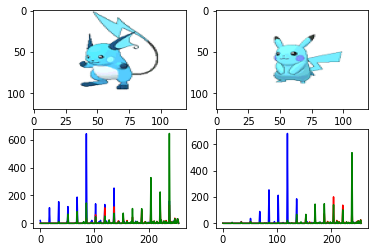

In [12]:
def plot_color_hist(image, mask=None):
    tmp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r  = cv2.split(image) # i removed a
    rgba = [b,g,r] # removing background by method 1 https://stackoverflow.com/questions/40527769/removing-black-background-and-make-transparent-from-grabcut-output-in-python-ope
    dst = cv2.merge(rgba,3)
    chans = cv2.split(dst)
    colors = ("b", "g", "r")
    rgb_hist = dict()
    for (chan, color) in zip(chans, colors):
        hist = cv2.calcHist([chan[np.where(chan < 255,True, False)]], [0], mask, [256], [0, 256])
        rgb_hist[color] = hist
    return rgb_hist

def compare_color_hist(img0_path : str , img1_path : str):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    im0 = axes[0,0].imshow(load_image(img0_path), aspect='auto')
    im1 = axes[0,1].imshow(load_image(img1_path), aspect='auto')
    plot0 = plot_color_hist(image=load_image(img0_path))
    #print(plot0)
    im2 = axes[1,0].plot(plot0["b"],color=('b'))
    im2 = axes[1,0].plot(plot0["r"],color=('r'))
    im2 = axes[1,0].plot(plot0["g"],color=('g'))
    plot1 = plot_color_hist(image=load_image(img1_path))
    im3 = axes[1,1].plot(plot1["b"],color=('b'))
    im3 = axes[1,1].plot(plot1["r"],color=('r'))
    im3 = axes[1,1].plot(plot1["g"],color=('g'))
#     return

compare_color_hist("./images_prepared/raichu.png","./images_prepared/pikachu.png" )

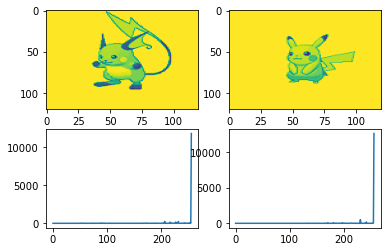

In [13]:
def plot_grey_hist(image, mask=None):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray[np.where(gray > 0,True, False)]], [0], None, [256], [0, 256])
    return hist

def compare_grey_hist(img0_path : str , img1_path : str):
    fig, axes = plt.subplots(nrows=2, ncols=2)
    im0 = axes[0,0].imshow(cv2.cvtColor(cv2.imread(img0_path), cv2.COLOR_BGR2GRAY), aspect='auto')
    im1 = axes[0,1].imshow(cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2GRAY), aspect='auto')
    plot0 = axes[1,0].plot(plot_grey_hist(image=load_image(img0_path)))
    plot1 = axes[1,1].plot(plot_grey_hist(image=load_image(img1_path)))
    return

compare_grey_hist("./images_prepared/raichu.png","./images_prepared/pikachu.png" )